In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import gpytorch
import math

In [36]:
X =torch.linspace(0, 1, 100)
Y = torch.sin(X * (2 * math.pi)) + torch.randn(X.size()) * 0.2

In [42]:
Y.shape

torch.Size([100])

In [43]:
common = pd.read_csv('/mnt/c/Users/aarge/workspace/ionstar_dataset/RT_benchmark2/data_from_single_model/testdata_Ax_By_1_6.txt',sep='\t')
# x
data_B = common['rt_y'].values
# y 
data_A = common['rt_x'].values
data_A.shape
#data_B = np.reshape(data_B, [common.shape[0], 1])
#data_A = np.reshape(data_A, [common.shape[0], 1])

(9386,)

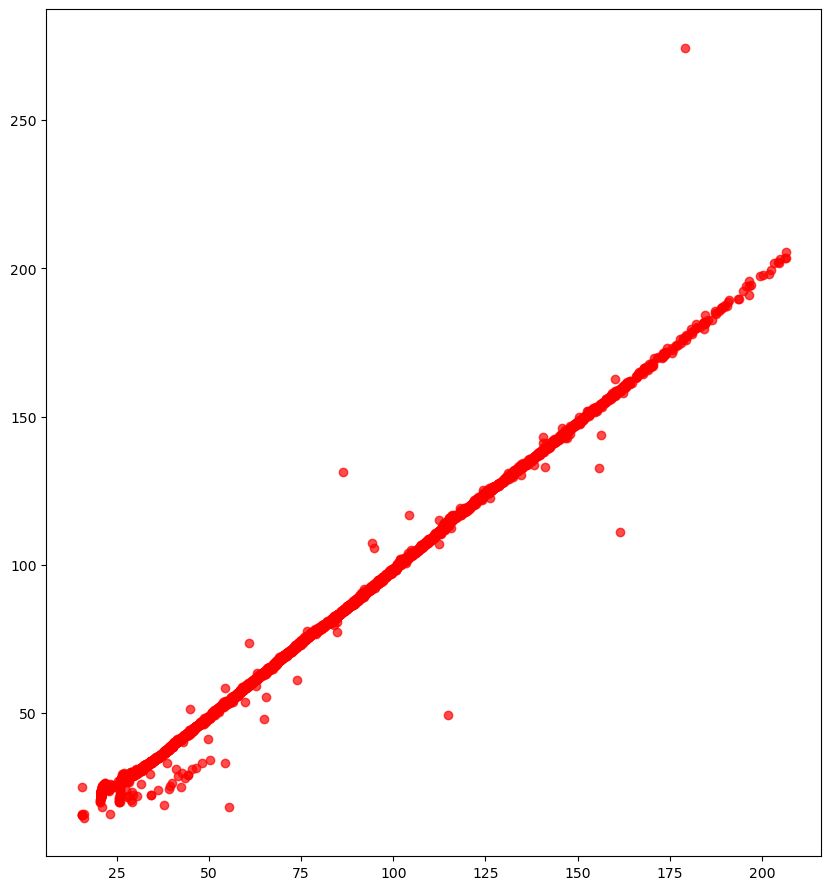

In [44]:
plt.figure(figsize=(10, 11) )

plt.scatter(data_B,data_A,alpha=0.7,color='red')
#plt.scatter(X_train[X_train > 180],y_train[X_train > 180],alpha=0.,color='blue')

In [45]:
X_train, X_test, y_train, y_test = train_test_split( data_B, data_A, test_size=.40, random_state=42)
print (X_train.shape)
print (y_test.shape)
X_train_ = torch.from_numpy(X_train)
y_train_ = torch.from_numpy(y_train)

(5631,)
(3755,)


tensor([ 33.5900,  48.4109,  37.0088,  ...,  64.3058, 139.8072,  82.5918],
       dtype=torch.float64)

# Set the GPy

In [48]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_, y_train_, likelihood)



In [49]:
# set up CUDA
X_train_ = X_train_.cuda()
y_train_ = y_train_.cuda()
model = model.cuda()
likelihood = likelihood.cuda()



In [50]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train_)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train_)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()



Iter 1/50 - Loss: 167.109   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 147.029   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 129.812   lengthscale: 0.798   noise: 0.798
Iter 4/50 - Loss: 115.061   lengthscale: 0.853   noise: 0.853
Iter 5/50 - Loss: 102.439   lengthscale: 0.910   noise: 0.909
Iter 6/50 - Loss: 91.581   lengthscale: 0.968   noise: 0.966
Iter 7/50 - Loss: 82.301   lengthscale: 1.027   noise: 1.024
Iter 8/50 - Loss: 74.338   lengthscale: 1.086   noise: 1.082
Iter 9/50 - Loss: 67.467   lengthscale: 1.146   noise: 1.140
Iter 10/50 - Loss: 61.537   lengthscale: 1.206   noise: 1.197
Iter 11/50 - Loss: 56.394   lengthscale: 1.265   noise: 1.253
Iter 12/50 - Loss: 51.939   lengthscale: 1.324   noise: 1.309
Iter 13/50 - Loss: 48.074   lengthscale: 1.382   noise: 1.363
Iter 14/50 - Loss: 44.685   lengthscale: 1.439   noise: 1.416
Iter 15/50 - Loss: 41.700   lengthscale: 1.495   noise: 1.467
Iter 16/50 - Loss: 39.084   lengthscale: 1.550   noise: 1.516
Iter 17/50 -

In [ ]:
X_test_ = X_test.cuda()
y_test_ = y_test.cuda()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test_))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()